<h1>Creating a New Thorn, Part 2</h1>
So far we've created an empty thorn which does nothing. Never before did doing nothing feel like such an accomplishment!

We can use it as a template for something more useful. To that end, we're going to create a thorn which computes an "energy," the sum of the squares of the wave velocities at each point on the grid. First, we create the source file itself. It's simple enough.

In [1]:
import os
os.environ["PATH"]="/opt/conda/envs/python2/bin:"+os.environ["PATH"]

In [2]:
!python --version

Python 2.7.12 :: Anaconda 4.2.0 (64-bit)


In [3]:
%cd ~/CactusFW2

/home/sbrandt/CactusFW2


In [4]:
%%writefile ./arrangements/FunwaveUtils/EnergyCalc/src/energy.cc
// We pretty much always want to include these 3 headers
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>

void compute_energy(CCTK_ARGUMENTS) // Cactus functions always have this prototype
{
    DECLARE_CCTK_ARGUMENTS; // Declare all grid functions (from interface.ccl)
    DECLARE_CCTK_PARAMETERS; // Declare all parameters (from param.ccl)
    
    // Note that even though this is really a 2-d calculation, Cactus
    // thinks of it as 3-d with 1 zone in the z direction.
    for(int k=0;k<cctk_lsh[2];k++) { // loop over the z direction
        for(int j=0;j<cctk_lsh[1];j++) { // loop over the y direction
            for(int i=0;i<cctk_lsh[0];i++) { // loop over the x direction
                int cc = CCTK_GFINDEX3D(cctkGH,i,j,k);
                energy[cc] = u[cc]*u[cc]+v[cc]*v[cc];
            }
        }
    }
}

Writing ./arrangements/FunwaveUtils/EnergyCalc/src/energy.cc


Next we update the makefile so that it will build. Are we done? Let's try to compile.

In [5]:
%%writefile arrangements/FunwaveUtils/EnergyCalc/src/make.code.defn
# Main make.code.defn file for thorn Energy

# Source files in this directory
SRCS = energy.cc

# Subdirectories containing source files
SUBDIRS =


Overwriting arrangements/FunwaveUtils/EnergyCalc/src/make.code.defn


In [6]:
!time ./simfactory/bin/sim build -j 2 --thornlist=./my_thorns.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
Parsing interface files...
   AEILocalInterp
           Implements: AEILocalInterp
           0 Public, 0 Protected, 0 Private variable groups
   Boundary
           Implements: boundary
           0 Public, 0 Protected, 0 Private variable groups
   Cactus
           Implements: Cactus
           0 Public, 0 Protected, 0 Private variable groups
   Carpet
           Implements: Driver
           0 Public, 0 Protected, 6 Private variable groups
   CarpetEvolutionMask
           Implements: CarpetEvolutionMask
           2 Public, 0 Protected, 0 Private variable groups
   CarpetIOASCII
           Implements: IOASCII
           0 Public, 0 Protected, 3 Private variable groups
   CarpetIOBasic
           Implements: IOBasic
           Inherits:  IO 
           0 Public, 0 Protected, 3 Privat

          0 Global, 0 Restricted, 35 Private parameters
   IOBasic
          0 Global, 0 Restricted, 13 Private parameters
   IOUtil
          0 Global, 59 Restricted, 2 Private parameters
   InitBase
          0 Global, 1 Restricted, 0 Private parameters
   InterpToArray
          0 Global, 93 Restricted, 0 Private parameters
   LocalInterp
          0 Global, 0 Restricted, 0 Private parameters
   LocalReduce
          0 Global, 0 Restricted, 0 Private parameters
   LoopControl
          0 Global, 0 Restricted, 20 Private parameters
   MPI
          0 Global, 0 Restricted, 0 Private parameters
   MoL
          0 Global, 9 Restricted, 26 Private parameters
   NaNChecker
          0 Global, 0 Restricted, 11 Private parameters
   SpaceMask
          0 Global, 1 Restricted, 0 Private parameters
   SphericalSurface
          0 Global, 15 Restricted, 9 Private parameters
   SymBase
          0 Global, 0 Restricted, 1 Private parameters
   SystemTopology
          0 Global, 0 Restricted, 2 P

Why did it fail? Two reasons. First, the grid function "energy" was not defined. Second, the code did not know how to access the velocity fields, "u" and "v."

To overcome the first problem, we decalare the "energy_group" below. To fix the second, we simply inherit from thorn Funwave where the velocities "u" and "v" are defined.

In [7]:
%%writefile ./arrangements/FunwaveUtils/EnergyCalc/interface.ccl
## Interface definitions for thorn Energy
inherits: Funwave
## An implementation name is required for all thorns. No
## two thorns in a configuration can implement the same
## interface.
implements: EnergyCalc

## the groups declared below can be public, private, or protected.
public:

## A group defines a set of variables that are allocated together
## and share common properties, i.e. timelevels, tags such as the
## Prolongation=None tag. The type tag can take on the values
## GF, Scalar, or Array.

## Note that the number of timelevels can be an integer parameter
## GF stands for "Grid Function" and refers to a distributed array
## data structure.
#cctk_real force_group type=GF timelevels=3 tags='Prolongation="None"'
#{
#  force1, force2
#}

cctk_real energy_group type=GF
{
    energy
}

## Scalars are single variables that are available on all processors.
#{
#  scalar1, scalar2
#}


Overwriting ./arrangements/FunwaveUtils/EnergyCalc/interface.ccl


With this change, everything should compile...

In [8]:
!time ./simfactory/bin/sim build -j 2 --thornlist=./my_thorns.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
Parsing interface files...
   AEILocalInterp
           Implements: AEILocalInterp
           0 Public, 0 Protected, 0 Private variable groups
   Boundary
           Implements: boundary
           0 Public, 0 Protected, 0 Private variable groups
   Cactus
           Implements: Cactus
           0 Public, 0 Protected, 0 Private variable groups
   Carpet
           Implements: Driver
           0 Public, 0 Protected, 6 Private variable groups
   CarpetEvolutionMask
           Implements: CarpetEvolutionMask
           2 Public, 0 Protected, 0 Private variable groups
   CarpetIOASCII
           Implements: IOASCII
           0 Public, 0 Protected, 3 Private variable groups
   CarpetIOBasic
           Implements: IOBasic
           Inherits:  IO 
           0 Public, 0 Protected, 3 Privat

          0 Global, 93 Restricted, 0 Private parameters
   LocalInterp
          0 Global, 0 Restricted, 0 Private parameters
   LocalReduce
          0 Global, 0 Restricted, 0 Private parameters
   LoopControl
          0 Global, 0 Restricted, 20 Private parameters
   MPI
          0 Global, 0 Restricted, 0 Private parameters
   MoL
          0 Global, 9 Restricted, 26 Private parameters
   NaNChecker
          0 Global, 0 Restricted, 11 Private parameters
   SpaceMask
          0 Global, 1 Restricted, 0 Private parameters
   SphericalSurface
          0 Global, 15 Restricted, 9 Private parameters
   SymBase
          0 Global, 0 Restricted, 1 Private parameters
   SystemTopology
          0 Global, 0 Restricted, 2 Private parameters
   TestCarpetGridInfo
          0 Global, 0 Restricted, 2 Private parameters
   TestLoopControl
          0 Global, 0 Restricted, 0 Private parameters
   Time
          0 Global, 2 Restricted, 5 Private parameters
   Timers
          0 Global, 0 Restricte

Done creating cactus_sim.
All done !
Building utilities for sim
Building utilities for sim
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOASCII/src/util/carpet2xgraph.c
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5toascii_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5tobinary_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_recombiner.cc
Copying gif2h5 from /usr/bin/gif2h5 to /home/sbrandt/CactusFW2/exe/sim
Copying h52gif from /usr/bin/h52gif to /home/sbrandt/CactusFW2/exe/sim
Copying h5copy from /usr/bin/h5copy to /home/sbrandt/CactusFW2/exe/sim
Copying h5debug from /usr/bin/h5debug to /home/sbrandt/CactusFW2/exe/sim
Copying h5diff from /usr/bin/h5diff to /home/sbrandt/CactusFW2/exe/sim
Copying h5dump from /usr/bin/h5dump to /home/sbrandt/CactusFW2/exe/sim
Copyi

So far so good. We've created a new thorn, including all the boiler plate code. We also filled in some source code and succeeded in compiling it. That's great. The only problem is, our thorn won't actually run. It's not scheduled to do so.

In [9]:
%%writefile ./arrangements/FunwaveUtils/EnergyCalc/schedule.ccl
## Schedule definitions for thorn Energy

## There won't be any storage allocated for a group
## unless a corresponding storage declaration exists
## for it in the schedule file. In square brackets,
## we specify the number of storage levels to allocate.
## These commented examples correspond to the commented
## examples in the interface file above.
# storage: force_group[3]
# storage: scalar_group

## Schedule a function defined in this thorn to run at the beginning
## of the simulation. The minimum you need to specify for a schedule
## item is what language it's written in. Choices are: C (which includes
## C++) and Fortran (which means Fortran90).
#SCHEDULE init_function at CCTK_INIT
#{
#  LANG: C
#}"Do some initial stuff"

schedule compute_energy in CCTK_ANALYSIS
{
    LANG: C
} "Compute the Energy for Analysis" # This comment is required!

Overwriting ./arrangements/FunwaveUtils/EnergyCalc/schedule.ccl


What does CCTK_ANALYSIS mean? Cactus schedules it's work in several bins. While there are many of them, here we only consider three:

1) CCTK_INITIAL - This runs once at the beginning. Initialize your grid functions here

2) CCTK_EVOL - Evolve a single timestep forward. This step will run repeatedly until the simulation finishes. Actually, this is rarely used directly. Usually, MoL_CalcRHS is used instead. More on that in a little bit.

3) CCTK_ANALYSIS - Called right before output routines. This ensures values are filled in sensibly. Call it to calculate values that you want to look at, but which aren't necessarily needed for the evolution.

In [10]:
!time ./simfactory/bin/sim build -j 2 --thornlist=./my_thorns.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
Parsing interface files...
   AEILocalInterp
           Implements: AEILocalInterp
           0 Public, 0 Protected, 0 Private variable groups
   Boundary
           Implements: boundary
           0 Public, 0 Protected, 0 Private variable groups
   Cactus
           Implements: Cactus
           0 Public, 0 Protected, 0 Private variable groups
   Carpet
           Implements: Driver
           0 Public, 0 Protected, 6 Private variable groups
   CarpetEvolutionMask
           Implements: CarpetEvolutionMask
           2 Public, 0 Protected, 0 Private variable groups
   CarpetIOASCII
           Implements: IOASCII
           0 Public, 0 Protected, 3 Private variable groups
   CarpetIOBasic
           Implements: IOBasic
           Inherits:  IO 
           0 Public, 0 Protected, 3 Privat

          0 Global, 0 Restricted, 35 Private parameters
   IOBasic
          0 Global, 0 Restricted, 13 Private parameters
   IOUtil
          0 Global, 59 Restricted, 2 Private parameters
   InitBase
          0 Global, 1 Restricted, 0 Private parameters
   InterpToArray
          0 Global, 93 Restricted, 0 Private parameters
   LocalInterp
          0 Global, 0 Restricted, 0 Private parameters
   LocalReduce
          0 Global, 0 Restricted, 0 Private parameters
   LoopControl
          0 Global, 0 Restricted, 20 Private parameters
   MPI
          0 Global, 0 Restricted, 0 Private parameters
   MoL
          0 Global, 9 Restricted, 26 Private parameters
   NaNChecker
          0 Global, 0 Restricted, 11 Private parameters
   SpaceMask
          0 Global, 1 Restricted, 0 Private parameters
   SphericalSurface
          0 Global, 15 Restricted, 9 Private parameters
   SymBase
          0 Global, 0 Restricted, 1 Private parameters
   SystemTopology
          0 Global, 0 Restricted, 2 P

Done creating cactus_sim.
All done !
Building utilities for sim
Building utilities for sim
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOASCII/src/util/carpet2xgraph.c
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5toascii_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5tobinary_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_recombiner.cc
Copying gif2h5 from /usr/bin/gif2h5 to /home/sbrandt/CactusFW2/exe/sim
Copying h52gif from /usr/bin/h52gif to /home/sbrandt/CactusFW2/exe/sim
Copying h5copy from /usr/bin/h5copy to /home/sbrandt/CactusFW2/exe/sim
Copying h5debug from /usr/bin/h5debug to /home/sbrandt/CactusFW2/exe/sim
Copying h5diff from /usr/bin/h5diff to /home/sbrandt/CactusFW2/exe/sim
Copying h5dump from /usr/bin/h5dump to /home/sbrandt/CactusFW2/exe/sim
Copyi

Now, let's find out what our code does! First, we'll need to create a par file. It will be similar to the one we created
in the first lesson. We will, however, make two small modifications.

In [11]:
%%writefile ~/CactusFW2/wave2.par

#Reorder the parameters for easy comparison to the input.txt in example 3
ActiveThorns = "
  CoordBase FunWave FunwaveCoord CartGrid3D Carpet CarpetIOASCII
  CartGrid3D IOUtil CarpetIOBasic CarpetSlab Boundary SymBase MoL
  CarpetReduce LocalReduce InitBase CarpetLib LoopControl Tridiagonal
  CarpetIOScalar EnergyCalc "

#----------------------------------------------------
# Flesh and CCTK parameters
#----------------------------------------------------

# flesh
Cactus::cctk_run_title = "Test Run"
Cactus::cctk_show_schedule = "yes"
Cactus::cctk_itlast = 300
Cactus::allow_mixeddim_gfs = "yes"

# CartGrid3D
CartGrid3D::type = "coordbase"
CartGrid3D::avoid_origin = "no"
CoordBase::domainsize = "minmax"
CoordBase::spacing    = "gridspacing"
CoordBase::xmin =  0
CoordBase::xmax =  30
CoordBase::ymin =  0
CoordBase::ymax =  30
CoordBase::zmin =  0.0
CoordBase::zmax =  0.0
CoordBase::dx   =  0.25
CoordBase::dy   =  0.25

CoordBase::boundary_size_x_lower     = 3
CoordBase::boundary_size_x_upper     = 3
CoordBase::boundary_size_y_lower     = 3
CoordBase::boundary_size_y_upper     = 3
CoordBase::boundary_size_z_lower     = 0
CoordBase::boundary_size_z_upper     = 0
CoordBase::boundary_shiftout_x_lower = 1
CoordBase::boundary_shiftout_x_upper = 1
CoordBase::boundary_shiftout_y_lower = 1
CoordBase::boundary_shiftout_y_upper = 1
CoordBase::boundary_shiftout_z_lower = 1
CoordBase::boundary_shiftout_z_upper = 1

# Carpet
Carpet::domain_from_coordbase = "yes"
Carpet::ghost_size_x = 3
Carpet::ghost_size_y = 3
Carpet::ghost_size_z = 1
carpet::adaptive_stepsize = yes

# MoL
MoL::ODE_Method = "RK3"
MoL::disable_prolongation        = "yes"

# the output dir will be named after the parameter file name
IO::out_dir = $parfile
IO::out_fileinfo="none"
IOBasic::outInfo_every = 1
IOBasic::outInfo_vars = "FunWave::eta FunWave::u FunWave::v"

#IOASCII::out1D_every = 1
#IOASCII::out1d_vars = "FunWave::eta Funwave::depth"
CarpetIOASCII::compact_format = false
IOASCII::out2D_every = 30
IOASCII::out2D_xyplane_z = 0
IOASCII::out2D_vars = "FunWave::eta FunWave::u FunWave::v EnergyCalc::energy"
IOASCII::out2D_xz = "no"
IOASCII::out2D_yz = "no"
IOASCII::output_ghost_points = "no"

IOScalar::outScalar_every = 1
IOScalar::outScalar_vars = "FunWave::eta FunWave::u FunWave::v"

#& = "Funwave::eta"

#----------------------------------------------------
# Funwave parameters
#----------------------------------------------------

# Funwave depth 
FunWave::depth_file_offset_x = 3
FunWave::depth_file_offset_y = 3
FunWave::depth_type = "flat"
FunWave::depth_format = "ele"
FunWave::depth_file = "/tmp/__depth__.txt"
FunWave::depth_flat = 0.8
#Funwave::test_depth_shore_x = 80
#Funwave::test_depth_island_x = 40
#Funwave::test_depth_island_y = 40
FunWave::depth_xslp = 10.0
FunWave::depth_slope = 0.05
FunWave::dt_size = 0
Funwave::generate_test_depth_data = true
Funwave::num_wave_components = 1
Funwave::wave_component_file = "/home/sbrandt/workspace/shi_funwave/example_2/fft/wavemk_per_amp_pha.txt"
Funwave::peak_period = 1

# import
Funwave::time_ramp = 1.0
Funwave::delta_wk = 0.5
Funwave::dep_wk = 0.45
Funwave::xc_wk = 3.0
Funwave::ywidth_wk = 10000.0
Funwave::tperiod = 1.0
Funwave::amp_wk = 0.0232
Funwave::theta_wk = 0.0
Funwave::freqpeak = 0.2
Funwave::freqmin = 0.1
Funwave::freqmax = 0.4
Funwave::hmo = 1.0
Funwave::gammatma = 5.0
Funwave::thetapeak = 10.0
Funwave::sigma_theta = 15.0

# Funwave wind forcing
Funwave::wind_force = false
Funwave::use_wind_mask = false
Funwave::num_time_wind_data = 2
Funwave::timewind[0] = 0
Funwave::wu[0] = 25
Funwave::wv[0] = 50
Funwave::timewind[1] = 1000
Funwave::wu[1] = 100
Funwave::wv[1] = 100
Funwave::boundary = funwave

# Funwave wave maker
FunWave::wavemaker_type = "ini_gau"
FunWave::xc = 26.5
FunWave::yc = 26.9
FunWave::amp =  2.0
FunWave::wid =  1
Funwave::wdep = 0.78
Funwave::xwavemaker = 25.0

# Funwave sponge 
FunWave::sponge_on = false
FunWave::sponge_west_width = 2.0
FunWave::sponge_east_width = 2.0
FunWave::sponge_north_width = 0.0
FunWave::sponge_south_width = 0.0
FunWave::sponge_decay_rate = 0.9
FunWave::sponge_damping_magnitude = 5.0

# Funwave dispersion (example 3 enables dispersion)
FunWave::dispersion_on = "true"
FunWave::gamma1 = 1.0
FunWave::gamma2 = 1.0
FunWave::gamma3 = 1.0
FunWave::beta_ref = -0.531
FunWave::swe_eta_dep = 0.80
FunWave::cd = 0.0

# Funwave numerics (MoL parameter controls time integration scheme)
FunWave::reconstruction_scheme = "fourth"
FunWave::riemann_solver = "HLLC"
FunWave::dtfac = 0.5
FunWave::froudecap = 10.0
FunWave::mindepth = 0.001
FunWave::mindepthfrc = 0.001
FunWave::enable_masks = "true"
Funwave::estimate_dt_on = "true"

FunwaveCoord::spherical_coordinates = false

ActiveThorns = "CarpetIOHDF5"
IOHDF5::out2D_xyplane_z = 0 
IOHDF5::out2D_every = 10
IOHDF5::out2D_vars = " 
  FunWave::eta
  FunWave::u
  FunWave::v
  Grid::Coordinates{out_every=1000000000}
"
IOHDF5::out2D_xz = no
IOHDF5::out2D_yz = no

Overwriting /home/sbrandt/CactusFW2/wave2.par


What, exactly, did we change? We can use diff to find out.

In [12]:
!diff wave.par wave2.par

7c7
<   CarpetIOScalar "
---
>   CarpetIOScalar EnergyCalc "
68c68
< IOASCII::out2D_vars = "FunWave::eta FunWave::u FunWave::v"
---
> IOASCII::out2D_vars = "FunWave::eta FunWave::u FunWave::v EnergyCalc::energy"


In [13]:
!rm -fr ~/simulations/wave2

In [14]:
%cd ~/CactusFW2
!./simfactory/bin/sim create-run --procs 2 --num-threads 1 wave2.par

/home/sbrandt/CactusFW2
Parameter file: /home/sbrandt/CactusFW2/wave2.par
Skeleton Created
Job directory: "/home/sbrandt/simulations/wave2"
Executable: "/home/sbrandt/CactusFW2/exe/cactus_sim"
Option list: "/home/sbrandt/simulations/wave2/SIMFACTORY/cfg/OptionList"
Submit script: "/home/sbrandt/simulations/wave2/SIMFACTORY/run/SubmitScript"
Run script: "/home/sbrandt/simulations/wave2/SIMFACTORY/run/RunScript"
Parameter file: "/home/sbrandt/simulations/wave2/SIMFACTORY/par/wave2.par"
Simulation name: wave2
Assigned restart id: 0 
Running simulation wave2
Preparing:
+ set -e
+ echo Checking:
Checking:
+ pwd
/home/sbrandt/simulations/wave2/output-0000
+ hostname
melete05.cct.lsu.edu
+ date
Mon Jul 31 12:27:12 CDT 2017
+ echo Environment:
Environment:
+ export CACTUS_NUM_PROCS=2
+ CACTUS_NUM_PROCS=2
+ export CACTUS_NUM_THREADS=1
+ CACTUS_NUM_THREADS=1
+ export GMON_OUT_PREFIX=gmon.out
+ GMON_OUT_PREFIX=gmon.out
+ export OMP_NUM_THREADS=1
+ OMP_NUM_THREADS=1
+ echo Starting:
Starting:
++ d

INFO (CycleClock): Calibrated CycleClock: 0.454549 ns per clock tick (2.19998 GHz)
  ____       _          __        __              
 / ___|__ _ (_)_   _ _ _\ \      / /_ ___   _____ 
| |   / _` || | | | | '_ \ \ /\ / / _` \ \ / / _ \
| |__| (_| || | |_| | | | \ V  V / (_| |\ V /  __/
 \____\__,_|/ |\__,_|_| |_|\_/\_/ \__,_| \_/ \___|
          |__/                                    
INFO (Vectors): Using vector size 1 for architecture scalar (no vectorisation, 64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
-----------------------------------

Where did things go wrong? We can re-run the simulation with gdb and get a stack trace to see.

In [15]:
!gdb ./exe/cactus_sim --eval-command="run wave2.par" --eval-command=where < /dev/null

GNU gdb (GDB) Red Hat Enterprise Linux 7.6.1-94.el7
Copyright (C) 2013 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.  Type "show copying"
and "show warranty" for details.
This GDB was configured as "x86_64-redhat-linux-gnu".
For bug reporting instructions, please see:
<http://www.gnu.org/software/gdb/bugs/>...
Reading symbols from /home/sbrandt/CactusFW2/exe/cactus_sim...done.
Starting program: /home/sbrandt/CactusFW2/./exe/cactus_sim wave2.par
[Thread debugging using libthread_db enabled]
Using host libthread_db library "/lib64/libthread_db.so.1".
--------------------------------------------------------------------------------

       10                                  
  1   0101       ************************  
  01  1010 10      The Cactus Code V4.2.3    
 1010 1101 011      www.cactuscode.org     
 

INFO (CycleClock): Calibrated CycleClock: 0.454547 ns per clock tick (2.19999 GHz)
  ____       _          __        __              
 / ___|__ _ (_)_   _ _ _\ \      / /_ ___   _____ 
| |   / _` || | | | | '_ \ \ /\ / / _` \ \ / / _ \
| |__| (_| || | |_| | | | \ V  V / (_| |\ V /  __/
 \____\__,_|/ |\__,_|_| |_|\_/\_/ \__,_| \_/ \___|
          |__/                                    
INFO (Vectors): Using vector size 1 for architecture scalar (no vectorisation, 64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
-----------------------------------

#9  0x0000000000590ec9 in CCTK_ScheduleTraverse (
    where=0xd31e87 "CCTK_ANALYSIS", GH=0x15eaa20, 
    CallFunction=0x9be7a0 <Carpet::CallFunction(void*, cFunctionData*, void*)>)
    at /home/sbrandt/CactusFW2/configs/sim/build/Cactus/main/ScheduleInterface.c:892
#10 0x000000000097ecfc in Carpet::ScheduleTraverse (
    name=name@entry=0xd31e87 "CCTK_ANALYSIS", cctkGH=cctkGH@entry=0x15eaa20, 
    where=0xda366a "CallAnalysis")
    at /home/sbrandt/CactusFW2/configs/sim/build/Carpet/Initialise.cc:1392
#11 0x000000000097fc5f in Carpet::CallAnalysis (cctkGH=cctkGH@entry=0x15eaa20, 
    did_recover=false)
    at /home/sbrandt/CactusFW2/configs/sim/build/Carpet/Initialise.cc:632
#12 0x0000000000981719 in Carpet::Initialise (fc=0x7fffffffeae0)
    at /home/sbrandt/CactusFW2/configs/sim/build/Carpet/Initialise.cc:131
#13 0x0000000000589633 in main (argc=2, argv=0x7fffffffebe8)
    at /home/sbrandt/CactusFW2/configs/sim/build/Cactus/main/flesh.cc:80
(gdb) quit
A debugging session is active.



The segfault occurs when we first attempt to write the energy variable. The problem is, Cactus has not allocated storage
for the variable. To do that, we must edit the schedule file and add a storage declaration for the energy_group.

In [16]:
%%writefile arrangements/FunwaveUtils/EnergyCalc/schedule.ccl
## Schedule definitions for thorn Energy

storage: energycalc::energy_group

## There won't be any storage allocated for a group
## unless a corresponding storage declaration exists
## for it in the schedule file. In square brackets,
## we specify the number of storage levels to allocate.
## These commented examples correspond to the commented
## examples in the interface file above.
# storage: force_group[3]
# storage: scalar_group

## Schedule a function defined in this thorn to run at the beginning
## of the simulation. The minimum you need to specify for a schedule
## item is what language it's written in. Choices are: C (which includes
## C++) and Fortran (which means Fortran90).
#SCHEDULE init_function at CCTK_INIT
#{
#  LANG: C
#}"Do some initial stuff"

schedule compute_energy in CCTK_ANALYSIS
{
    LANG: C
} "Compute the Energy for Analysis" # This comment is required!

Overwriting arrangements/FunwaveUtils/EnergyCalc/schedule.ccl


In [17]:
!time ./simfactory/bin/sim build -j 2 --thornlist=./my_thorns.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
Parsing interface files...
   AEILocalInterp
           Implements: AEILocalInterp
           0 Public, 0 Protected, 0 Private variable groups
   Boundary
           Implements: boundary
           0 Public, 0 Protected, 0 Private variable groups
   Cactus
           Implements: Cactus
           0 Public, 0 Protected, 0 Private variable groups
   Carpet
           Implements: Driver
           0 Public, 0 Protected, 6 Private variable groups
   CarpetEvolutionMask
           Implements: CarpetEvolutionMask
           2 Public, 0 Protected, 0 Private variable groups
   CarpetIOASCII
           Implements: IOASCII
           0 Public, 0 Protected, 3 Private variable groups
   CarpetIOBasic
           Implements: IOBasic
           Inherits:  IO 
           0 Public, 0 Protected, 3 Privat

          0 Global, 93 Restricted, 0 Private parameters
   LocalInterp
          0 Global, 0 Restricted, 0 Private parameters
   LocalReduce
          0 Global, 0 Restricted, 0 Private parameters
   LoopControl
          0 Global, 0 Restricted, 20 Private parameters
   MPI
          0 Global, 0 Restricted, 0 Private parameters
   MoL
          0 Global, 9 Restricted, 26 Private parameters
   NaNChecker
          0 Global, 0 Restricted, 11 Private parameters
   SpaceMask
          0 Global, 1 Restricted, 0 Private parameters
   SphericalSurface
          0 Global, 15 Restricted, 9 Private parameters
   SymBase
          0 Global, 0 Restricted, 1 Private parameters
   SystemTopology
          0 Global, 0 Restricted, 2 Private parameters
   TestCarpetGridInfo
          0 Global, 0 Restricted, 2 Private parameters
   TestLoopControl
          0 Global, 0 Restricted, 0 Private parameters
   Time
          0 Global, 2 Restricted, 5 Private parameters
   Timers
          0 Global, 0 Restricte

Done creating cactus_sim.
All done !
Building utilities for sim
Building utilities for sim
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOASCII/src/util/carpet2xgraph.c
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5toascii_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5tobinary_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_slicer.cc
Compiling /home/sbrandt/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_recombiner.cc
Copying gif2h5 from /usr/bin/gif2h5 to /home/sbrandt/CactusFW2/exe/sim
Copying h52gif from /usr/bin/h52gif to /home/sbrandt/CactusFW2/exe/sim
Copying h5copy from /usr/bin/h5copy to /home/sbrandt/CactusFW2/exe/sim
Copying h5debug from /usr/bin/h5debug to /home/sbrandt/CactusFW2/exe/sim
Copying h5diff from /usr/bin/h5diff to /home/sbrandt/CactusFW2/exe/sim
Copying h5dump from /usr/bin/h5dump to /home/sbrandt/CactusFW2/exe/sim
Copyi

In [18]:
!rm -fr ~/simulations/wave2

In [19]:
!./simfactory/bin/sim create-run --procs 2 --num-threads 1 wave2.par

Parameter file: /home/sbrandt/CactusFW2/wave2.par
Skeleton Created
Job directory: "/home/sbrandt/simulations/wave2"
Executable: "/home/sbrandt/CactusFW2/exe/cactus_sim"
Option list: "/home/sbrandt/simulations/wave2/SIMFACTORY/cfg/OptionList"
Submit script: "/home/sbrandt/simulations/wave2/SIMFACTORY/run/SubmitScript"
Run script: "/home/sbrandt/simulations/wave2/SIMFACTORY/run/RunScript"
Parameter file: "/home/sbrandt/simulations/wave2/SIMFACTORY/par/wave2.par"
Simulation name: wave2
Assigned restart id: 0 
Running simulation wave2
Preparing:
+ set -e
+ echo Checking:
Checking:
+ pwd
/home/sbrandt/simulations/wave2/output-0000
+ hostname
melete05.cct.lsu.edu
+ date
Mon Jul 31 12:30:44 CDT 2017
+ echo Environment:
Environment:
+ export CACTUS_NUM_PROCS=2
+ CACTUS_NUM_PROCS=2
+ export CACTUS_NUM_THREADS=1
+ CACTUS_NUM_THREADS=1
+ export GMON_OUT_PREFIX=gmon.out
+ GMON_OUT_PREFIX=gmon.out
+ export OMP_NUM_THREADS=1
+ OMP_NUM_THREADS=1
+ echo Starting:
Starting:
++ date +%s
+ export CACTUS_

INFO (CycleClock): Calibrated CycleClock: 0.454549 ns per clock tick (2.19998 GHz)
  ____       _          __        __              
 / ___|__ _ (_)_   _ _ _\ \      / /_ ___   _____ 
| |   / _` || | | | | '_ \ \ /\ / / _` \ \ / / _ \
| |__| (_| || | |_| | | | \ V  V / (_| |\ V /  __/
 \____\__,_|/ |\__,_|_| |_|\_/\_/ \__,_| \_/ \___|
          |__/                                    
INFO (Vectors): Using vector size 1 for architecture scalar (no vectorisation, 64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
-----------------------------------

        3     1.048 |   -0.7827099    0.7827247 |   -0.7908120    0.7945910 | -2.204493e-13    1.7406879
        4     1.071 |   -0.9871958    0.9871304 |   -1.0078458    1.0085949 | -8.400691e-14    1.5989647
        5     1.094 |   -1.1744423    1.1742063 |   -1.1909363    1.1836515 | -1.710410e-15    1.4476202
        6     1.117 |   -1.3292681    1.3289617 |   -1.3316063    1.3201955 | -1.152414e-14    1.2961226
        7     1.140 |   -1.4464243    1.4460941 |   -1.4436961    1.4892265 | -7.675744e-14    1.1507342
        8     1.162 |   -1.5469224    1.5458777 |   -1.6224632    1.6048745 | -9.317621e-16    1.0141344
        9     1.185 |   -1.6090563    1.6066068 |   -1.7050094    1.6735034 | -3.912694e-15    0.8880859
       10     1.208 |   -1.6386679    1.6345209 |   -1.7530102    1.7107463 | -4.626260e-15    0.7717948
       11     1.230 |   -1.8563836    1.8480030 |   -1.7674885    1.7295325 | -2.510327e-14    0.6754319
       12     1.253 |   -1.6739634    1.6693377 |   -1.

       70     2.615 |   -1.4642912    0.2767483 |   -1.4057981    0.2590229 |   -0.2137260    0.5887379
       71     2.640 |   -1.4474711    0.2761392 |   -1.3962712    0.2583219 |   -0.1941274    0.5831460
       72     2.664 |   -1.4513894    0.2742674 |   -1.4019325    0.2548907 |   -0.1721779    0.5784937
       73     2.688 |   -1.4414570    0.2710084 |   -1.3995690    0.2490426 |   -0.1655913    0.5714285
       74     2.713 |   -1.4288063    0.2647984 |   -1.3864879    0.2420549 |   -0.1676511    0.5688352
       75     2.738 |   -1.4283104    0.2554700 |   -1.3908008    0.2340046 |   -0.1698992    0.5647703
       76     2.762 |   -1.4137836    0.2437063 |   -1.3822609    0.2265682 |   -0.1718507    0.5740248
       77     2.787 |   -1.4091300    0.2367836 |   -1.3767554    0.2179821 |   -0.1737959    0.5916501
       78     2.812 |   -1.4046636    0.2274053 |   -1.3758512    0.2130156 |   -0.1766506    0.6169808
       79     2.836 |   -1.3859611    0.2155210 |   -1.3619419  

      137     4.300 |   -1.0608795    0.2156183 |   -1.0674998    0.2167764 |   -0.3671624    0.4946664
      138     4.328 |   -1.0548312    0.2188421 |   -1.0619842    0.2287137 |   -0.3667662    0.4851986
      139     4.356 |   -1.0463378    0.2180459 |   -1.0607194    0.2396080 |   -0.3661865    0.4839073
-------------------------------------------------------------------------------------------------------
Iteration      Time |                FUNWAVE::u |                FUNWAVE::v |              FUNWAVE::eta
                    |      minimum      maximum |      minimum      maximum |      minimum      maximum
-------------------------------------------------------------------------------------------------------
      140     4.384 |   -1.0467500    0.2169481 |   -1.0500058    0.2512368 |   -0.3654015    0.4747634
      141     4.412 |   -1.0378406    0.2186419 |   -1.0497144    0.2630811 |   -0.3642819    0.4724773
      142     4.440 |   -1.0342172    0.2163659 |   -1.0453023  

      201     6.149 |   -0.8533410    0.3717816 |   -0.8152867    0.4101634 |   -0.1750078    0.3320730
      202     6.180 |   -0.8535028    0.3681777 |   -0.8146050    0.4101118 |   -0.1751810    0.3311869
      203     6.210 |   -0.8442866    0.3647292 |   -0.8119215    0.4102397 |   -0.1756846    0.3295971
      204     6.240 |   -0.8425213    0.3612682 |   -0.8052784    0.4114481 |   -0.1757903    0.3285272
      205     6.271 |   -0.8400223    0.3594254 |   -0.8062386    0.4125626 |   -0.1758510    0.3263323
      206     6.301 |   -0.8282626    0.3601502 |   -0.8010470    0.4150443 |   -0.1762802    0.3253608
      207     6.332 |   -0.8316114    0.3606417 |   -0.7985980    0.4163994 |   -0.1765009    0.3236009
      208     6.362 |   -0.8263956    0.3617883 |   -0.7971293    0.4196593 |   -0.1764601    0.3225128
      209     6.393 |   -0.8192261    0.3630934 |   -0.7894353    0.4223273 |   -0.1769458    0.3202863
      210     6.424 |   -0.8197248    0.3634221 |   -0.7909435  

      268     8.269 |   -0.6734256    0.4059333 |   -0.6535384    0.4421553 |   -0.1577800    0.2217224
      269     8.302 |   -0.6756800    0.4045318 |   -0.6554061    0.4411120 |   -0.1571127    0.2206535
      270     8.334 |   -0.6711322    0.4046642 |   -0.6501599    0.4390332 |   -0.1563702    0.2209410
      271     8.367 |   -0.6710783    0.4044379 |   -0.6510131    0.4387896 |   -0.1558859    0.2205042
      272     8.400 |   -0.6706263    0.4032953 |   -0.6504622    0.4380201 |   -0.1553208    0.2189918
      273     8.432 |   -0.6644033    0.4028924 |   -0.6438784    0.4362545 |   -0.1545145    0.2199283
      274     8.465 |   -0.6678908    0.4028691 |   -0.6477349    0.4349431 |   -0.1541124    0.2190905
      275     8.497 |   -0.6647396    0.4019592 |   -0.6447659    0.4344681 |   -0.1535710    0.2188659
      276     8.530 |   -0.6627175    0.4007857 |   -0.6422107    0.4330321 |   -0.1528491    0.2185265
      277     8.563 |   -0.6636459    0.4009477 |   -0.6438056  

Now let's plot our energy function. Basically, we're just copying cells from the Cactus-Funwave notebook.

In [20]:
# This cell enables inline plotting in the notebook
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [21]:
import matplotlib.cm as cm
# https://matplotlib.org/examples/color/colormaps_reference.html
cmap = cm.gist_rainbow

In [22]:
import os
dir = os.environ["HOME"]+"/simulations/wave2/output-0000/wave2/"
file_data = np.genfromtxt(dir+"energy.xy.asc")

sets= [   0.   30.   60.   90.  120.  150.  180.  210.  240.  270.  300.]
which= 0.0
min/max= 0.0 0.0


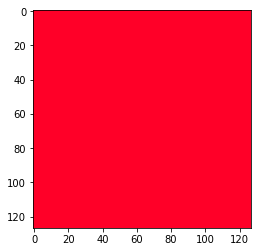

which= 30.0
min/max= 9.01208895889e-56 1.65537953034


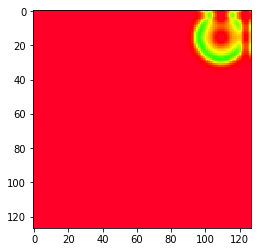

which= 60.0
min/max= 2.19682234385e-48 3.38527411759


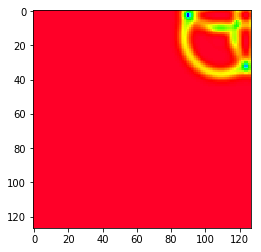

which= 90.0
min/max= 2.38140954126e-42 4.43301815684


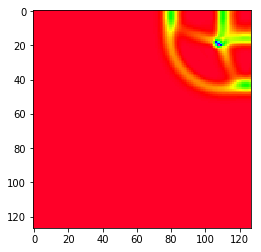

which= 120.0
min/max= 5.00570857867e-37 1.77377800008


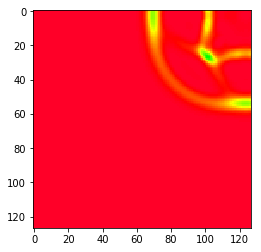

which= 150.0
min/max= 7.13738424883e-32 1.11634950128


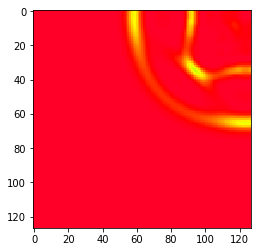

which= 180.0
min/max= 3.43927946471e-27 0.917869038217


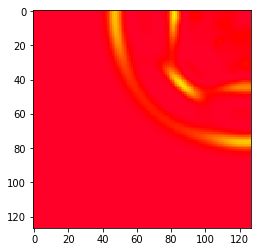

which= 210.0
min/max= 7.34416173737e-23 0.714989981487


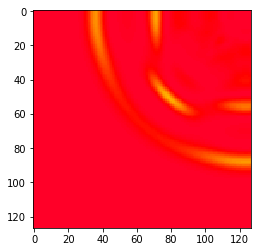

which= 240.0
min/max= 7.9823699496e-19 0.547130159319


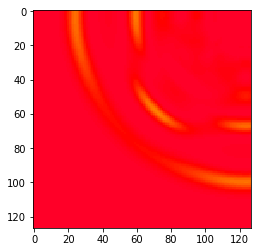

which= 270.0
min/max= 3.76714634697e-15 0.450438624114


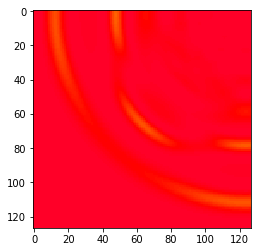

which= 300.0
min/max= 7.41478202381e-12 0.396822944513


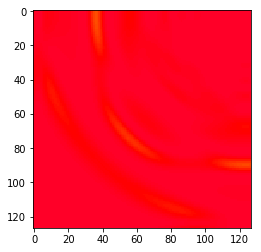

In [23]:
sets = np.unique(file_data[:,0])
width = 8
height = 4
print("sets=",sets)
mn, mx = np.min(file_data[:,12]),np.max(file_data[:,12])
for which in sets: 
    print("which=",which)
    g = file_data[file_data[:,0]==which,:]
    x = g[:,5]
    y = g[:,6]
    z = g[:,12]
    zi = z.reshape(len(np.unique(y)),len(np.unique(x)))
    print('min/max=',np.min(zi),np.max(zi))
    plt.figure(figsize=(width, height))
    plt.imshow(zi[::-1,:],cmap,clim=(mn,mx))
    plt.show()

Exercise:
Make a copy of both "CreatingANewThorn" notebooks and edit them to create another new thorn, "LaplacianEta" which computes the Laplacian of the eta variable, which is a measure of the displacement of the surface of the water from rest. Like the "Energy" thorn, this quantity will be computed at analysis time.

The second derivative of a quantity is approximated by the finite difference formula:

$f''[x] = (f[x+dx] - 2 f[x] + f[x-dx])/dx^2 \approx ((f[x]+dx f'[x]+\frac{1}{2}dx^2 f[x]+...) - 2 f[x] + (f[x]-dx f'[x]+\frac{1}{2}dx^2 f[x]+...))/dx^2$

In terms of Cactus, f[x] and f[x+dx] might look something like this...
<pre>
  int cc = CCTK_GFINDEX3D(cctkGH,i,j,k)
  int cp1 = CCTK_GFINDEX3D(cctkGH,i+1,j,k)
  CCTK_REAL fx = f[cc]; // If this is f[x]
  CCTK_REAL fx1 = f[cp1]; // this is f[x+dx]
</pre>

Cactus provides an additional array of integers, like cctk_lsh, called cctk_delta_space, which provides the quantities dx, dy, and dz (these are cctk_delta_space[0], cctk_delta_space[1] and cctk_delta_space[2], respecitively).

Because this is a 2-d code, the Laplacian is

$\Delta^2 \eta = \left( \frac{d^2}{dx^2} + \frac{d^2}{dy^2} \right) \eta$

Note that you will not be able to calculate the value of the Laplacian at the borders of the grid, as that would result in a segfault. Please write zeroes in the borders instead.

Note also that Funwave defines grid variables dx and dy. You can use dx[cc] (where cc = CCTK_GFINDEX3D(cctkGH,i,j,k)) in place of cctk_delta_space[0] if you want to. You can't, however, redefined dx or dy.

<table><tr><td>This work sponsored by NSF grants <a href="https://www.nsf.gov/awardsearch/showAward?AWD_ID=1550551"> OAC 1550551</a> and <a href="https://www.nsf.gov/awardsearch/showAward?AWD_ID=1539567"> CCF 1539567</a></td><td><img src="https://www.nsf.gov/awardsearch/images/common/nsf_logo_bottom.png"></tr></table>